Dendrogram
---------
Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram).

Dendrogram represent the difference between each node starting from the closest ones.

In [5]:
import pandas as pd
import tools

from sklearn.feature_extraction.text import TfidfVectorizer

Preparing data set
------------------

In Clustering nbs the preperation of data set is discussed. 

In [6]:
df = pd.read_json('/home/nightwing/rsc/Axelbib/scraping/Analysis of Results/data.json')

In [7]:
df = df.drop(['labels', 'list_strategies', 'provenance', 'read', 'pages', 'score', 'key'], 1)

keywords = df.groupby('unique_key')['key_word'].apply(lambda x: ','.join(x)).reset_index()['key_word']
authors = df.groupby('unique_key')['author'].apply(lambda x: ','.join(x)).reset_index()['author']

df = df.drop_duplicates('unique_key')

df['key_word'] = list(keywords)
df['author']  = list(authors)

In [8]:
df['features'] = df['abstract'] + df['title'] + df['date'].apply(str) + df['author'] + df['key_word']

Term Weighting
-------------

As described in Clustering. The sklearn library is used. http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [9]:
# create a tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, 
                                   min_df=0.01, 
                                   tokenizer=tools.tokenize_text, ngram_range=(2,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.features)

CPU times: user 26.6 s, sys: 0 ns, total: 26.6 s
Wall time: 26.7 s


In [10]:
terms = tfidf_vectorizer.get_feature_names()

Dendrogram
---------

Links on dendrograms: 
- http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
- http://84.89.132.1/~michael/stanford/maeb7.pdf

In [11]:
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
%matplotlib inline

A dendogram is plotting the difference between a pair. For vector space models one of the most famous similarity measures is the cosine measure.

The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not taking into the consideration only the magnitude of each word count (tf-idf) of each document, but the angle between the documents

http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [14]:
dist = cosine_similarity(tfidf_matrix)
linkage_matrix = hierarchy.ward(dist)

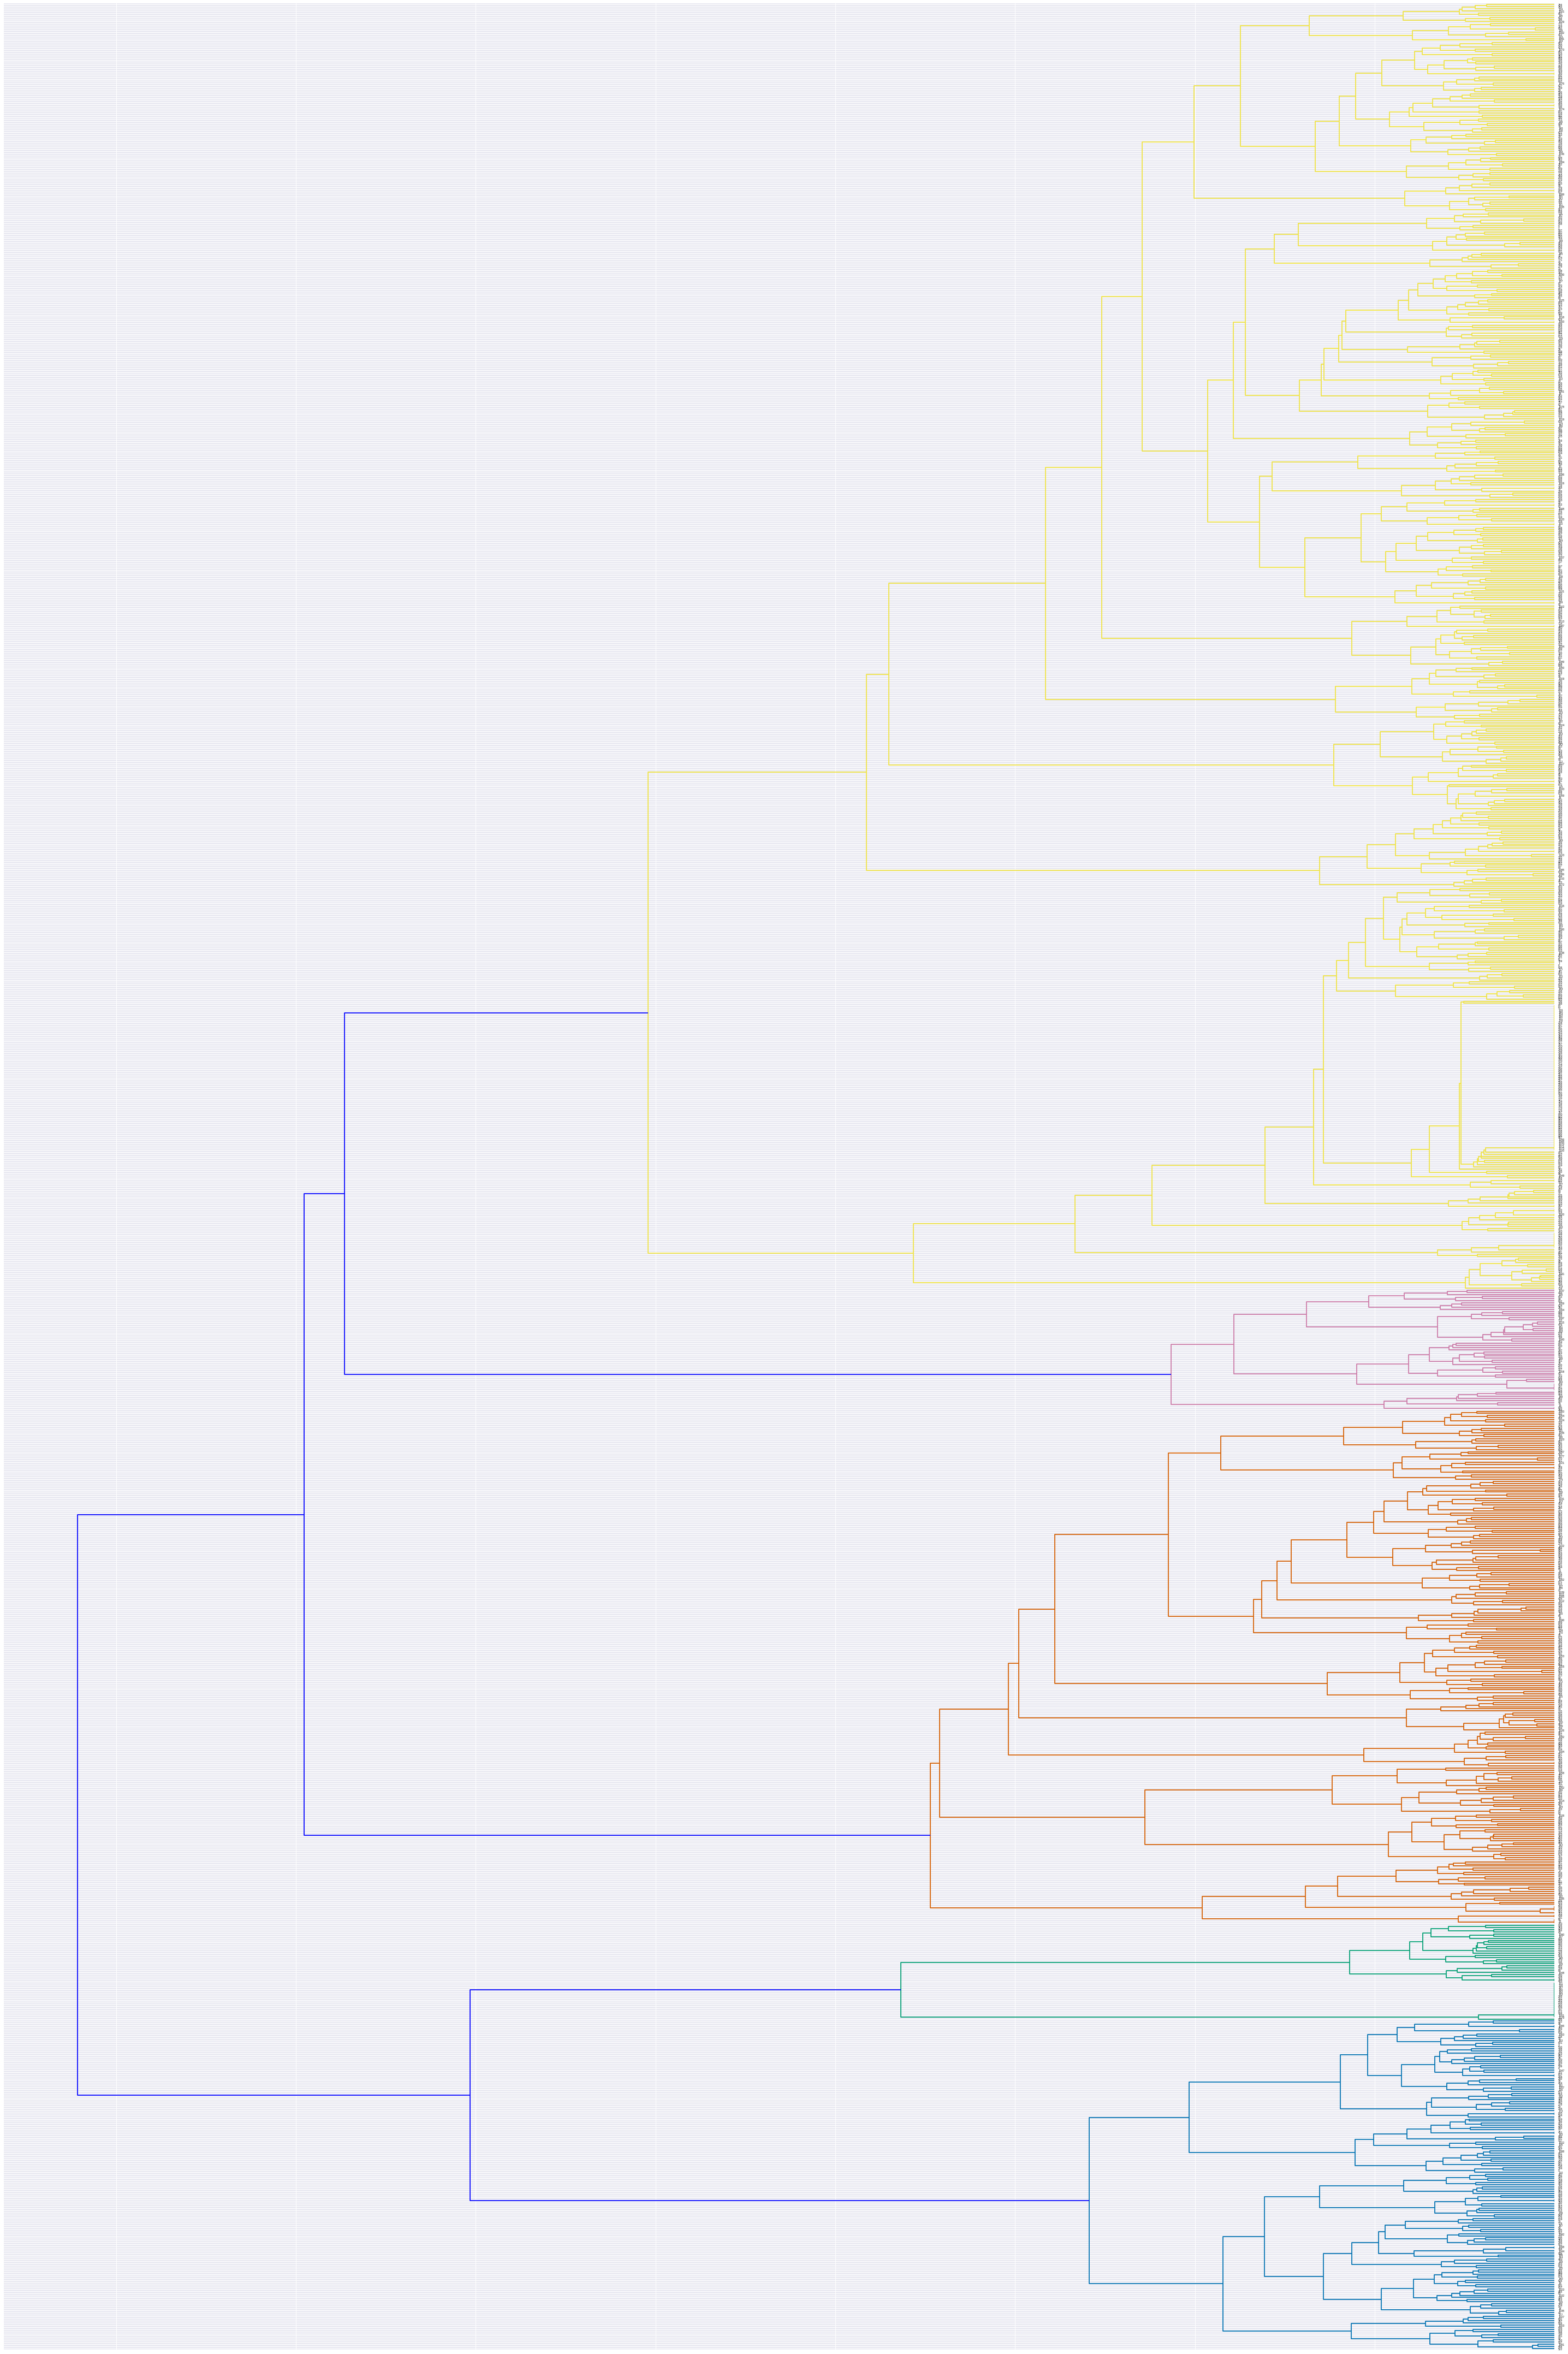

In [15]:
link_color_pal = sns.color_palette("colorblind")
hierarchy.set_link_color_palette([rgb2hex(i) for i in link_color_pal])


fig, ax = plt.subplots(figsize=(40, 60))
ax = hierarchy.dendrogram(linkage_matrix, orientation="left");

plt.tick_params(\
    axis= 'x',         
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 
#plt.savefig("/home/nightwing/rsc/Literature-Article/src/img/exp-4.1.pdf", format='pdf', bbox_inches='tight')

Removing Keywords
-----------------

In [17]:
def tokenize_text(raw_text):
    raw_text = tools.clean_text(raw_text)
    # spacy function to get tokens
    tokens = tools.parser(raw_text)

    # lemmatize
    lemmas = []
    for tok in tokens:
        # if tok.like_num == False:
        lemmas.append(
            tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # remove stopwords & symbols
    tokens = [tok for tok in tokens if tok not in tools.STOPLIST]
    tokens = [tok for tok in tokens if tok not in tools.SYMBOLS]
    tokens = [tok for tok in tokens if tok not in tools.SPECIAL_CHAR]

    tokens = [tok for tok in tokens if tok not in tools.NON_TERMS]

    # remove spaces if they exist
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, 
                                   min_df=0.01, 
                                   tokenizer=tokenize_text,
                                   ngram_range=(2,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.features)

CPU times: user 20.7 s, sys: 4 ms, total: 20.7 s
Wall time: 20.7 s


In [19]:
dist = cosine_similarity(tfidf_matrix)
linkage_matrix = hierarchy.ward(dist)

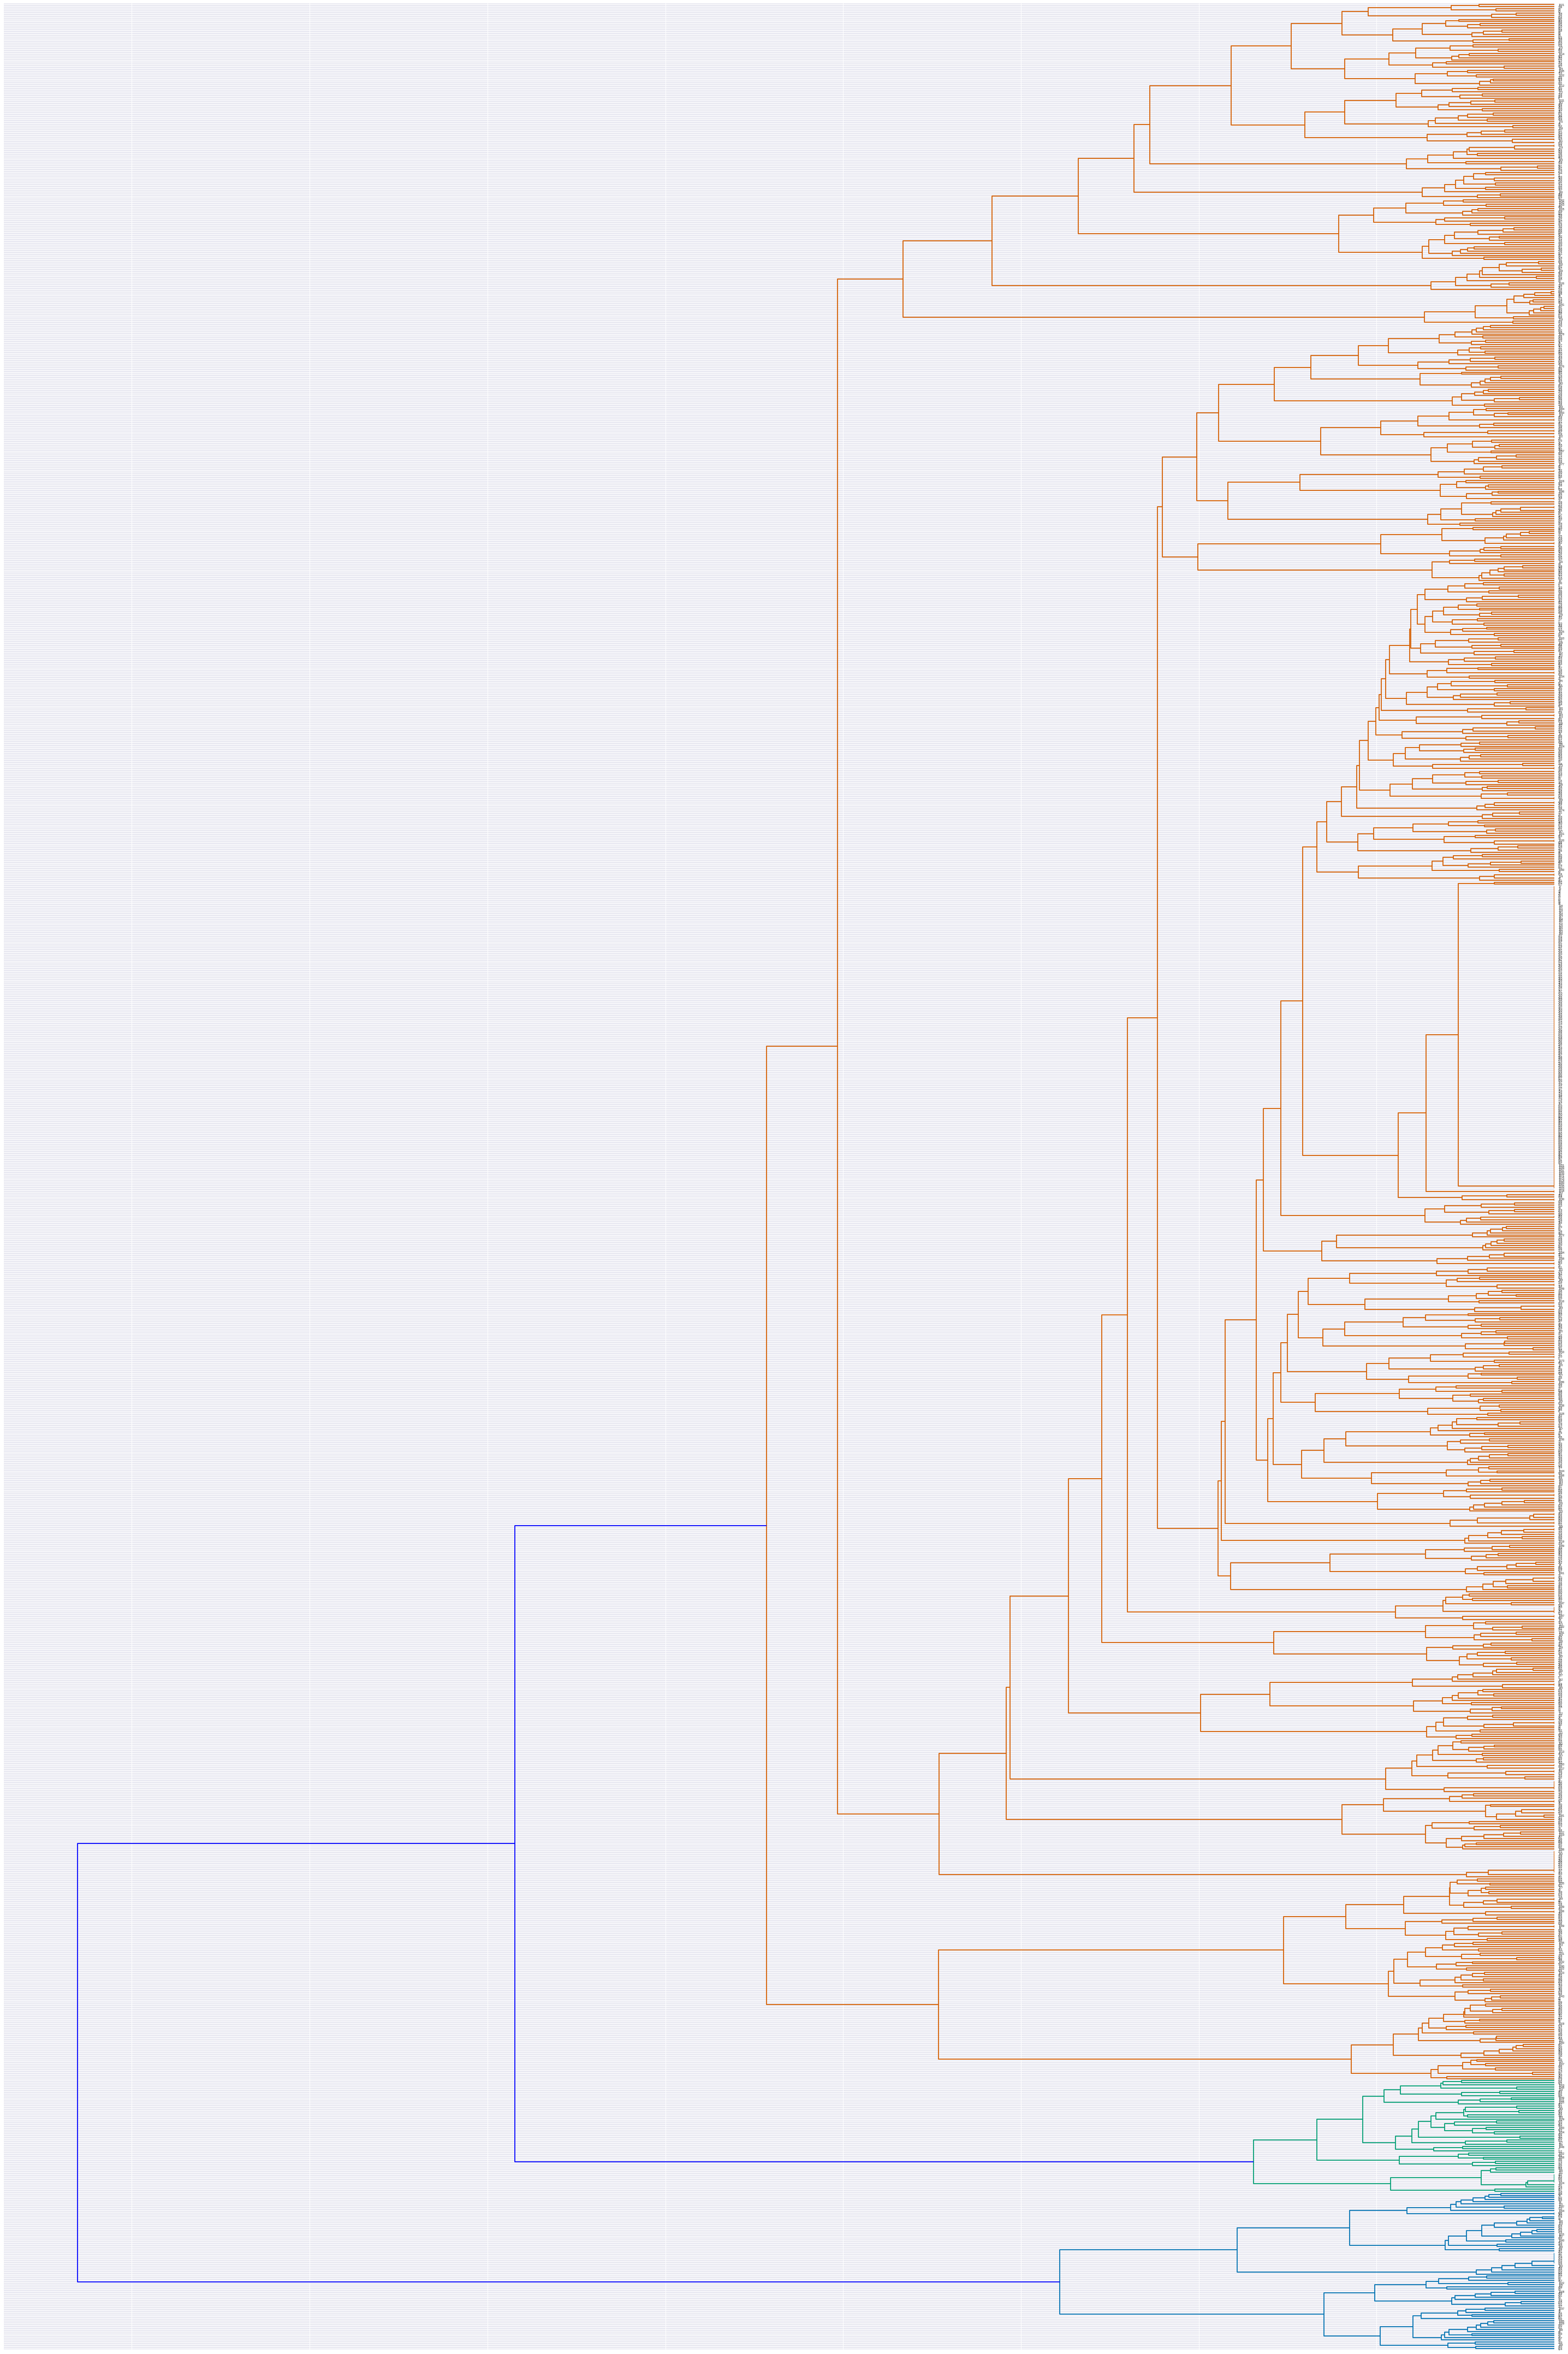

In [20]:
link_color_pal = sns.color_palette("colorblind")
hierarchy.set_link_color_palette([rgb2hex(i) for i in link_color_pal])


fig, ax = plt.subplots(figsize=(40, 60))
ax = hierarchy.dendrogram(linkage_matrix, orientation="left");

plt.tick_params(\
    axis= 'x',         
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 
#plt.savefig("/home/nightwing/rsc/Literature-Article/src/img/exp-4.1.pdf", format='pdf', bbox_inches='tight')